<a href="https://colab.research.google.com/github/JaisSolutions/AgilePractice/blob/main/Abiola_Oluwole_work_on_foam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

!pip install tensorflow-gpu==2.0.0-beta0
!pip install tensorflow_hub
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import os
#https://medium.com/analytics-vidhya/create-tensorflow-image-classification-model-with-your-own-dataset-in-google-colab-63e9d7853a3e

In [ ]:
! pip install tensorflow==2.15.0 tensorflow-hub keras==2.15.0

In [ ]:
# Get the data, unpack it, and remove zip file
%%capture

! wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/3ryWwuCv2-U0sw -O ./foam.zip
! unzip ./foam.zip
! rm -f foam.zip

In [ ]:
len(os.listdir('./foam/bad')), len(os.listdir('./foam/good'))

(2540, 1038)

In [ ]:
IMAGE_SHAPE = (224, 224)
data_root='./foam'
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.2)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

./foam
Found 715 images belonging to 2 classes.
Found 2863 images belonging to 2 classes.


In [ ]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['Bad' 'Good']


In [ ]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Epoch 1/10
90/90 [==============================] - 170s 2s/step - loss: 0.0824 - acc: 0.9658 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 2/10
90/90 [==============================] - 158s 2s/step - loss: 0.0066 - acc: 0.9993 - val_loss: 0.0018 - val_acc: 1.0000
Epoch 3/10
90/90 [==============================] - 146s 2s/step - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 4/10
90/90 [==============================] - 131s 1s/step - loss: 0.0029 - acc: 1.0000 - val_loss: 7.7040e-04 - val_acc: 1.0000
Epoch 5/10
90/90 [==============================] - 146s 2s/step - loss: 0.0018 - acc: 1.0000 - val_loss: 5.6618e-04 - val_acc: 1.0000
Epoch 6/10
90/90 [==============================] - 129s 1s/step - loss: 0.0015 - acc: 1.0000 - val_loss: 4.6089e-04 - val_acc: 1.0000
Epoch 7/10
90/90 [==============================] - 149s 2s/step - loss: 9.9125e-04 - acc: 1.0000 - val_loss: 3.8789e-04 - val_acc: 1.0000
Epoch 8/10
90/90 [==============================] - 139s 2s/ste

In [ ]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

1/1 [==============================] - 2s 2s/step
Prediction results for the first elements


,Bad,Good
0,0.000001,0.999999
1,0.999965,0.000035
2,0.000023,0.999977
3,0.000149,0.999851
4,0.999988,0.000012


In [ ]:
true_label_ids

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

In [ ]:
np.argmax(tf_model_predictions, axis=-1)

array([1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0])

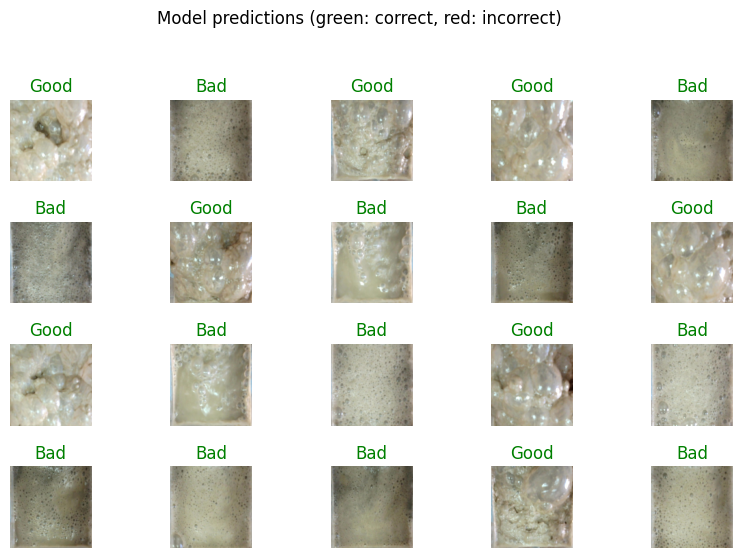

In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
    plt.subplot(6,5,n+1)
    plt.imshow(val_image_batch[n])
    color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
    plt.title(predicted_labels[n].title(), color=color)
    plt.axis('off')
    _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [ ]:
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import *
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import applications
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K

from sklearn.model_selection import train_test_split

import matplotlib.cm as cm
from numpy import expand_dims

In [ ]:
class EnoughPerformanceReached(Callback):
    """
    Callback for stopping training when the performance is greater than <threshold>.
    """

    def __init__(self, threshold):
        self.monitor = "val_categorical_accuracy"
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs):
        current_accuracy = logs.get(self.monitor)
        if current_accuracy >= self.threshold:
            print(f"[INFO] Enough performance reached: {current_accuracy}")
            self.model.stop_training = True

# Function for plotting images.
def plot_sample(X):
    """
    Given the array of images <X>, it plots a random subsample of 25 images.

        Parameters:
            X (ndarray): The array with all the images.
    """
    # Plotting 25 sample images
    nb_rows = 5
    nb_cols = 5
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis("off")
            axs[i, j].imshow(X[random.randint(0, X.shape[0] - 1)])

    plt.show()


def read_data(path_list, im_size=(224, 224)):
    """
    Given the list of paths where the images are stored <path_list>,
    and the size for image decimation <im_size>, it returns 2 Numpy Arrays
    with the images and labels; and a dictionary with the mapping between
    classes and folders. This will be used later for displaying the predicted
    labels.

        Parameters:
            path_list (List[String]): The list of paths to the images.
            im_size (Tuple): The height and width values.

        Returns:
            X (ndarray): Images
            y (ndarray): Labels
            tag2idx (dict): Map between labels and folders.
    """

    X = []
    y = []

    # Exctract the file-names of the datasets we read and create a label dictionary.
    tag2idx = {tag.split(os.path.sep)[-1]: i for i, tag in enumerate(path_list)}

    for path in path_list:
        for im_file in tqdm(glob(path + "*/*")):  # Read all files in path
            try:
                # os.path.separator is OS agnostic (either '/' or '\'),[-2] to grab folder name.
                label = im_file.split(os.path.sep)[-2]
                im = cv2.imread(im_file, cv2.IMREAD_COLOR)
                # By default OpenCV read with BGR format, return back to RGB.
                im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                # Resize to appropriate dimensions.You can try different interpolation methods.
                im = cv2.resize(im, im_size, interpolation=cv2.INTER_AREA)
                X.append(im)
                y.append(tag2idx[label])  # Append the label name to y
            except Exception as e:
                # In case annotations or metadata are found
                print("Not a picture")

    X = np.array(X)  # Convert list to numpy array.
    y = np.eye(len(np.unique(y)))[y].astype(np.uint8)
    idx2tag = {v: k for k, v in tag2idx.items()}

    return X, y, idx2tag


# Callbacks are used for saving the best weights and
# early stopping.
def get_callbacks(weights_file, patience, lr_factor):
    """
    Callbacks are used for saving the best weights and early stopping.
    Given some configuration parameters, it creates the callbacks that
    will be used by Keras after each epoch.

        Parameters:
            weights_file (String): File name for saving the best model weights.
            patience (Integer): Number of epochs without improvement to wait.
            lr_factor: Factor for reducing the learning rate when performance
                       is not improving.

        Returns:
            callbacks (List[Callbacks]): Configured callbacks ready to use.
    """
    return [
        # Only save the weights that correspond to the maximum validation accuracy.
        ModelCheckpoint(
            filepath=weights_file,
            monitor="val_categorical_accuracy",
            mode="max",
            save_best_only=True,
            save_weights_only=True,
        ),
        # If val_loss doesn't improve for a number of epochs set with 'patience' var
        # training will stop to avoid overfitting.
        EarlyStopping(
            monitor="val_categorical_accuracy", mode="max", patience=patience, verbose=1
        ),
        EnoughPerformanceReached(0.99),
        # Learning rate is reduced by 'lr_factor' if val_loss stagnates
        # for a number of epochs set with 'patience' var.
        ReduceLROnPlateau(
            monitor="val_loss",
            mode="min",
            factor=lr_factor,
            min_lr=1e-6,
            patience=patience // 2,
            verbose=1,
        ),
    ]

In [ ]:
# Last Convolutional Layer of EfficientNetB0
LAST_CONV_LAYER_NAME = (
    "top_activation"  # Name of the layer from where the gradients are computed
)

In [ ]:
def get_img_array(image):
    """
    This function adds a dimension to transform the array into the "batch"
    of size (1, NUM_ROWS, NUM_COLUMNS, NUM_CHANNELS) that Keras needs.
    """
    image = np.expand_dims(image, axis=0)
    return image


def plot_features(image, class_name, true_label, class_channel, heatmap):
    """
    Given the <image> and the <heatmap>, this function displays the
    Grad-CAM output on the image, besides additional information such as
    <class_name>, <true_label> and <class_channel>.
    """
    # Display heatmap
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 3, 1)
    plt.title("Grad-CAM Convolution", fontsize=8)
    plt.imshow(heatmap)
    heatmap = cv2.resize(heatmap, IM_SIZE)
    plt.subplot(1, 3, 2)

    plt.title(
        f"Truth: {true_label} - Predicted: {class_name.split('-')[0]} ({round(100*class_channel[0])}%)",
        fontsize=6,
    )
    plt.imshow(img_array[0].astype(np.uint8))
    plt.axis("off")
    plt.subplot(1, 3, 3)

    plt.title("Heatmap", fontsize=8)
    plt.imshow(img_array[0].astype(np.uint8))
    plt.imshow(heatmap, alpha=0.5)
    plt.axis("off")

    plt.show()


def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """
    Given the image (<img_array>), the trained <model> and the name of the
    last convolutional layer <last_conv_layer_name>, this functions computes
    the heatmap with the relevance of each feature.
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_name = idx2tag[K.eval(pred_index)]
        # print(preds)
        class_channel = preds[:, pred_index]  # Class-Proba
        # print(class_channel)

    # We compute the gradient of the top predicted output neuron
    # with regard to the output feature map of the last conv layer
    # Intuitively, it tells us how important each channel is with regard
    # to the target class.
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel. The gradients thus obtained are then
    # global average pooled to obtain the neuron important weights corresponding
    # to the target class.
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation.
    # In other words, we multiply each activation map with corresponding pooled gradients
    # which acts as weights determining how important each channel is with regard
    # to the target class.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy(), class_name, K.eval(class_channel)

In [ ]:
test_paths = [
    "./foam/bad/image1.jpg",
    "./foam/bad/image10.jpg",
    "./foam/good/image1.jpg",
    "./foam/good/image1.jpg",
]

true_labels = ["bad", "bad", "good", "good"]

In [ ]:
plot_sample

<function __main__.plot_sample(X)>

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# 18 - d, 16 - c

# 74
# 68

tn = 12 / 18
fp = 6 / 18

tp = 13 / 16
fn = 3 / 16

f1_1 = 2*tp/(2*tp + fn + fp)
f1_2 = 2*tn/(2*tn + fn + fp)
print((f1_1+f1_2)/2)

0.738191338496782


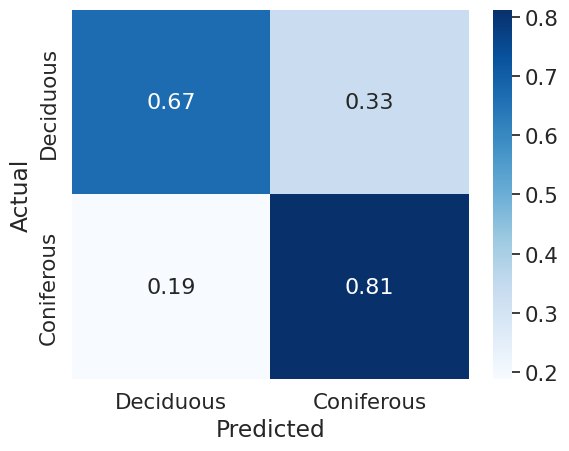

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

array = [[tn,fp],
         [fn,tp]]

#df_cm = pd.DataFrame(array, range(2), range(2))
df_cm = pd.DataFrame(array, index = ["Deciduous", "Coniferous"],
                  columns = ["Deciduous", "Coniferous"])
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}) # font size
# labels, title and ticks


plt.show()